In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Fetching data from the API
url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=57c5aef9-70f9-4b71-82fa-52304cfbd031&limit=1000'
with urllib.request.urlopen(url) as fileobj:
    data = fileobj.read().decode('utf-8')
    #print(data)

In [ ]:
# Parsing the JSON response
import json
json_data = json.loads(data)
records = json_data['result']['records']
df = pd.DataFrame(records)
data = df.copy()

In [ ]:
# Display the first few rows of the dataframe to understand its structure
data.head()

,_id,OID,SUMACCIDEN,ID,CITY,MainUse,POP_2018,TAZAREA,USETYPE,CITYCODE,...,TOTDRIVERS,MOTORCYCLE,TRUCK,BICYCLE,PRIVATE,VEHICLE,ACC_INDEX,YEARMONTH,Shape_Length,Shape_Area
0,1,-1,56,544,ראשון לציון,מגורים,9948,852978,מגורים,8300,...,89,22,1,4,40,75,65.652368,202308,3765.786446,8.529776e+05
1,2,-1,11,2172,טבריה,מגורים,6378,1475818,מגורים,6700,...,23,2,0,2,11,15,7.453496,202308,6981.506526,1.475818e+06
2,3,-1,20,1186,ירושלים,מגורים,12277,346241,מגורים,3000,...,32,2,0,1,17,27,57.763205,202308,3958.161078,3.462412e+05
3,4,-1,10,137,הרצלייה,מגורים,5341,499512,מגורים,6400,...,16,1,0,1,10,12,20.019541,202308,3065.801740,4.995120e+05
4,5,-1,44,1828,קריית אתא,שטח פתוח,0,508601,פנאי/טבע/ספורט,6800,...,97,2,3,0,68,79,86.511780,202308,3692.333819,5.086013e+05


In [ ]:
import re

# תבניות רגולריות להחלפה
patterns = [
    (r'\bתעשיה\+ מגורים\b', 'תעשיה+מגורים'),
    (r'\bמגורים\+ מכללה אקדמאית\b', 'מגורים+מכללה אקדמאית'),
    (r'\bתעשיה\+ מכללה\b', 'תעשיה+מכללה'),
    (r'\bמגורים\+ בית חולים\b', 'מגורים+בית חולים'),
    (r'\bמגורים\+ שטח פתוח\b', 'מגורים+שטח פתוח'),
    (r'\bמגורים\+ מסחר\b', 'מגורים+מסחר'),
    (r'\bמגורים \+ אצטדיון\b', 'מגורים+אצטדיון'),
    (r'\bמגורים\+ מוסד אקדמאי\b', 'מגורים+מוסד אקדמאי'),
    (r'\bאוניברסיטה\+ בית חולים\b', 'אוניברסיטה+בית חולים'),
    (r'\bפנאי וספורט\+ מגורים\b', 'פנאי וספורט+מגורים'),
    (r'\bמסחר\+ מתקן ספורט\+ מגורים\b', 'מסחר+מתקן ספורט+מגורים'),
    (r'\bמגורים\+ מוסדיי\b', 'מגורים+מוסדי'),
    (r'\bמגורים\+ מוסדי\b', 'מגורים+מוסדי'),
    (r'\bמתקן הנדסי\+ מגורים\b', 'מתקן הנדסי+מגורים'),
    (r'\bמגורים\+ פנאי ונופש\b', 'מגורים+פנאי ונופש'),
    (r'\bקריית חינוך\+ מכללה אקדמאית\b', 'קריית חינוך+מכללה אקדמאית'),
    (r'\bמתקן לתחבורה\+ מגורים\b', 'מתקן לתחבורה+מגורים'),
    (r'\bמתחם ציבורי\+ מכללה אקדמאית\b', 'מתחם ציבורי+מכללה אקדמאית'),
    (r'\bמוסדות ציבור\+ מכללה אקדמאית\b', 'מוסדות ציבור+מכללה אקדמאית'),
    (r'\bמגורים\+ מכללה אקדמאית\+ בית חולים\b', 'מגורים+מכללה אקדמאית+בית חולים'),
    (r'\bמתקן ספורט\+ מגורים\b', 'מתקן ספורט+מגורים')
]

# החלפת תבניות בדאטה
for pattern, replacement in patterns:
    data['MainUse'] = data['MainUse'].apply(lambda x: re.sub(pattern, replacement, x))



In [ ]:
data['MainUse'].value_counts()


מגורים                             660
שטח פתוח                            95
לא ידוע                             65
תעשיה                               60
בסיס צבאי                            9
מיועד למגורים                        8
מגורים+מוסדי                         8
פנאי ונופש                           6
מתחם ציבורי                          5
בית עלמין                            5
בית חולים                            5
מגורים+מכללה אקדמאית                 5
תעשיה+מגורים                         4
אוניברסיטה                           4
תעשיה ומלאכה                         4
מוסדי                                4
תיירות ונופש                         4
תעשיה ומסחר                          4
מגורים+שטח פתוח                      3
מגורים+פנאי ונופש                    3
תשעיה                                2
מגורים+בית חולים                     2
שדה תעופה                            2
מתקן הנדסה                           2
שטח לדרכים                           2
נמל                      

In [ ]:
print(data[data['POP_2018'] == 0]['MainUse'].value_counts())


שטח פתוח                      94
לא ידוע                       65
תעשיה                         51
בסיס צבאי                      9
מיועד למגורים                  8
פנאי ונופש                     5
בית עלמין                      5
בית חולים                      5
תעשיה ומלאכה                   4
תיירות ונופש                   4
אוניברסיטה                     4
מתחם ציבורי                    3
תעשיה ומסחר                    3
תשעיה                          2
נמל                            2
שטח לדרכים                     2
מגורים                         2
שדה תעופה                      2
מתקן הנדסה                     2
מחצבה                          1
קריית חינוך+מכללה אקדמאית      1
מוסדות ציבור                   1
ספורט                          1
מתקן מיחזור                    1
תשתיות                         1
שטח בבניה                      1
שמורת טבע                      1
מוסדות ציבור+מכללה אקדמאית     1
מוסדי                          1
תעשיה+מכללה                    1
קריית הממש

In [ ]:
#מילוי חציון לערכי מגורים בלבד כאשר הערכים שווים ל0
median_population_zero_mainuse = data.loc[(data['POP_2018'] == 0) & (data['MainUse'] == 'מגורים'), 'POP_2018'].median()

 # שינוי ערכי ה־0 בעמודת 'MainUse' לערכי החציון
data.loc[(data['POP_2018'] == 0) & (data['MainUse'] == 'מגורים'), 'POP_2018'] = median_population_zero_mainuse

print(data[data['POP_2018'] == 0]['MainUse'].value_counts())




שטח פתוח                      94
לא ידוע                       65
תעשיה                         51
בסיס צבאי                      9
מיועד למגורים                  8
פנאי ונופש                     5
בית עלמין                      5
בית חולים                      5
תעשיה ומלאכה                   4
תיירות ונופש                   4
אוניברסיטה                     4
מתחם ציבורי                    3
תעשיה ומסחר                    3
תשעיה                          2
נמל                            2
שטח לדרכים                     2
מגורים                         2
שדה תעופה                      2
מתקן הנדסה                     2
מחצבה                          1
קריית חינוך+מכללה אקדמאית      1
מוסדות ציבור                   1
ספורט                          1
מתקן מיחזור                    1
תשתיות                         1
שטח בבניה                      1
שמורת טבע                      1
מוסדות ציבור+מכללה אקדמאית     1
מוסדי                          1
תעשיה+מכללה                    1
קריית הממש

In [ ]:
columns_to_drop = ['_id', 'OID', 'ID', 'USETYPECOD']
data.drop(columns=columns_to_drop, inplace=True)


In [ ]:
data

,SUMACCIDEN,CITY,MainUse,POP_2018,TAZAREA,USETYPE,CITYCODE,DEAD,SEVER_INJ,SLIGH_INJ,...,TOTDRIVERS,MOTORCYCLE,TRUCK,BICYCLE,PRIVATE,VEHICLE,ACC_INDEX,YEARMONTH,Shape_Length,Shape_Area
0,56,ראשון לציון,מגורים,9948,852978,מגורים,8300,0,14,51,...,89,22,1,4,40,75,65.652368,202308,3765.786446,8.529776e+05
1,11,טבריה,מגורים,6378,1475818,מגורים,6700,0,1,19,...,23,2,0,2,11,15,7.453496,202308,6981.506526,1.475818e+06
2,20,ירושלים,מגורים,12277,346241,מגורים,3000,0,4,25,...,32,2,0,1,17,27,57.763205,202308,3958.161078,3.462412e+05
3,10,הרצלייה,מגורים,5341,499512,מגורים,6400,0,0,10,...,16,1,0,1,10,12,20.019541,202308,3065.801740,4.995120e+05
4,44,קריית אתא,שטח פתוח,0,508601,פנאי/טבע/ספורט,6800,0,10,106,...,97,2,3,0,68,79,86.511780,202308,3692.333819,5.086013e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15,רמת השרון,מגורים,3906,293440,מגורים,2650,0,3,13,...,19,2,0,0,12,16,51.117745,202308,2560.613740,2.934402e+05
996,3,יקנעם עילית,מגורים,2149,1189827,מגורים,240,0,1,2,...,4,0,0,0,4,4,2.521375,202308,6699.620537,1.189827e+06
997,30,חופית נעורים כפר ויתקין בית ינאי מכמורת בית חי...,מגורים+מוסדי,6271,14391839,מגורים,0,1,13,72,...,69,5,5,1,38,56,2.084515,202308,18694.291028,1.439184e+07
998,12,הזורעים אלומות פורייה - כפר עבודה פורייה - נוו...,מגורים,4138,29885695,מגורים,0,0,5,27,...,25,0,0,0,17,18,0.401530,202308,53211.852368,2.988569e+07


In [ ]:
# Check for missing values in each column
missing_values = data.isnull().sum()
missing_values

SUMACCIDEN        0
CITY              0
MainUse           0
POP_2018          0
TAZAREA           0
USETYPE           0
CITYCODE          0
DEAD            135
SEVER_INJ       135
SLIGH_INJ       135
PEDESTRINJ      135
INJ0_19         135
INJ20_64        135
INJ65_          135
INJTOTAL        135
TOTDRIVERS      135
MOTORCYCLE      135
TRUCK           135
BICYCLE         135
PRIVATE         135
VEHICLE         135
ACC_INDEX         0
YEARMONTH         0
Shape_Length      0
Shape_Area        0
dtype: int64

In [ ]:
# Percentage of missing values
missing_percentage = (missing_values / len(data)) * 100

In [ ]:
#תצוגה של הערכים החסרים והאחזוים שלהם
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_summary.sort_values(by='Percentage', ascending=False)

In [ ]:
# Fill missing values with 0
columns_with_missing_values = missing_summary[missing_summary['Missing Values'] > 0].index
data_filled = data.fillna(0)

In [ ]:
# Verify if the missing values are filled
missing_values_after = data_filled.isnull().sum()
missing_values_after_summary = pd.DataFrame({'Missing Values After Filling': missing_values_after})
missing_values_after_summary[missing_values_after_summary['Missing Values After Filling'] > 0]
#חוזרת רשימה ריקה וזה אומר שאין ערכים חסרים


,Missing Values After Filling


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Values After Filling']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Values After Filling'}, axis=1)
              .sort_values('Missing Values After Filling', ascending=True))
  xs = counted['Missing Values After Filling']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('Missing Values After Filling', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Values After Filling')
_ = plt.ylabel('count()')

In [ ]:
# Summary statistics for numerical columns to assess the need for normalization
#numerical_columns = data_filled.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = data_filled.select_dtypes(include=[np.number]).columns
statistical_summary = data_filled[numerical_columns].describe()

statistical_summary.transpose()
#בדיקה של כל העמודות המספריות על מנת לבדוק את טווח הערכים שלהן

,count,mean,std,min,25%,50%,75%,max
SUMACCIDEN,1000.0,1.674000e+01,2.078943e+01,0.000000,2.750000,10.000000,2.300000e+01,2.010000e+02
POP_2018,1000.0,3.314479e+03,3.455537e+03,0.000000,0.000000,2860.000000,5.335750e+03,2.902200e+04
TAZAREA,1000.0,1.155787e+07,5.318930e+07,140532.000000,393122.500000,830103.000000,3.364000e+06,7.859678e+08
CITYCODE,1000.0,3.377874e+03,3.332946e+03,0.000000,0.000000,2715.000000,6.700000e+03,9.700000e+03
ACC_INDEX,1000.0,2.621258e+01,4.928557e+01,0.000000,0.828345,6.319367,2.869625e+01,4.608733e+02
YEARMONTH,1000.0,2.023080e+05,0.000000e+00,202308.000000,202308.000000,202308.000000,2.023080e+05,2.023080e+05
Shape_Length,1000.0,9.890644e+03,1.543621e+04,1504.375748,2898.377449,4344.896712,9.679891e+03,1.396824e+05
Shape_Area,1000.0,1.155787e+07,5.318930e+07,140532.315685,393122.360474,830102.996382,3.363999e+06,7.859678e+08


In [ ]:
# Selecting numerical columns for normalization
columns_to_normalize = ['POP_2018', 'TAZAREA', 'TOTDRIVERS', 'MOTORCYCLE', 'TRUCK', 'BICYCLE', 'PRIVATE', 'VEHICLE', 'ACC_INDEX']

In [ ]:
# Normalizing selected numerical columns
scaler = MinMaxScaler()
data_filled[columns_to_normalize] = scaler.fit_transform(data_filled[columns_to_normalize])

In [ ]:
# Encoding categorical variables
categorical_columns = ['CITY', 'MainUse', 'USETYPE']
onehot_encoder = OneHotEncoder(sparse=False)
encoded_categorical = onehot_encoder.fit_transform(data_filled[categorical_columns])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# # Creating a DataFrame from the encoded categorical variables
# encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out(categorical_columns))
# import pandas as pd

# Creating a DataFrame from the encoded categorical variables
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.feature_names_out_)


AttributeError: 'OneHotEncoder' object has no attribute 'feature_names_out_'

In [ ]:
# Dropping original categorical columns and concatenating the encoded ones
data_preprocessed = data_filled.drop(columns=categorical_columns)
data_preprocessed = pd.concat([data_preprocessed, encoded_categorical_df], axis=1)

NameError: name 'encoded_categorical_df' is not defined

In [ ]:
# Displaying a summary of the transformed dataset
data_preprocessed.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
SUMACCIDEN,1000.0,16.740000,20.789435,0.0,2.750000,10.000000,23.000000,201.0
POP_2018,1000.0,0.114206,0.119066,0.0,0.000000,0.098546,0.183852,1.0
TAZAREA,1000.0,0.014529,0.067686,0.0,0.000321,0.000878,0.004102,1.0
CITYCODE,1000.0,3377.874000,3332.946458,0.0,0.000000,2715.000000,6700.000000,9700.0
TOTDRIVERS,1000.0,0.078035,0.099411,0.0,0.010101,0.045455,0.106692,1.0


In [ ]:
# Calculating new features: Accident density per population and per area
#This line calculates the accident density per population. It divides the number of accidents (`SUMACCIDEN`) by the product of the population in 2018 (`POP_2018`)
#and the maximum population squared plus 1. This calculation likely aims to normalize the accident count based on the population density, considering the maximum population value.
data_preprocessed['Accident_Density_Per_Population'] = data_preprocessed['SUMACCIDEN'] / (data_preprocessed['POP_2018'] * data_preprocessed['POP_2018'].max() + 1)

#This line calculates the accident density per area. It divides the number of accidents (`SUMACCIDEN`) by the product of the Total Analysis Zone area (`TAZAREA`)
#and the maximum area squared plus 1. This calculation likely aims to normalize the accident count based on the area size, considering the maximum area value.

data_preprocessed['Accident_Density_Per_Area'] = data_preprocessed['SUMACCIDEN'] / (data_preprocessed['TAZAREA'] * data_preprocessed['TAZAREA'].max() + 1)

#these calculations normalize the accident counts based on population and area sizes to provide insights into accident density per capita and per area, respectively.


In [ ]:
# Displaying the first few rows to check the new features
data_preprocessed[['Accident_Density_Per_Population', 'Accident_Density_Per_Area']].head()

,Accident_Density_Per_Population,Accident_Density_Per_Area
0,41.704696,55.949275
1,9.018136,10.981340
2,14.054578,19.994766
3,8.445712,9.995434
4,44.000000,43.979401


In [ ]:
#סכום שורות מכל עיר
city_counts = data['CITY'].value_counts()
print(city_counts)

ירושלים                  82
תל אביב -יפו             54
חיפה                     47
באר שבע                  28
פתח תקווה                27
                         ..
יסעור אחיהוד              1
עפרה                      1
כישור תובל לפידות פלך     1
שגב-שלום                  1
הר גילה                   1
Name: CITY, Length: 374, dtype: int64


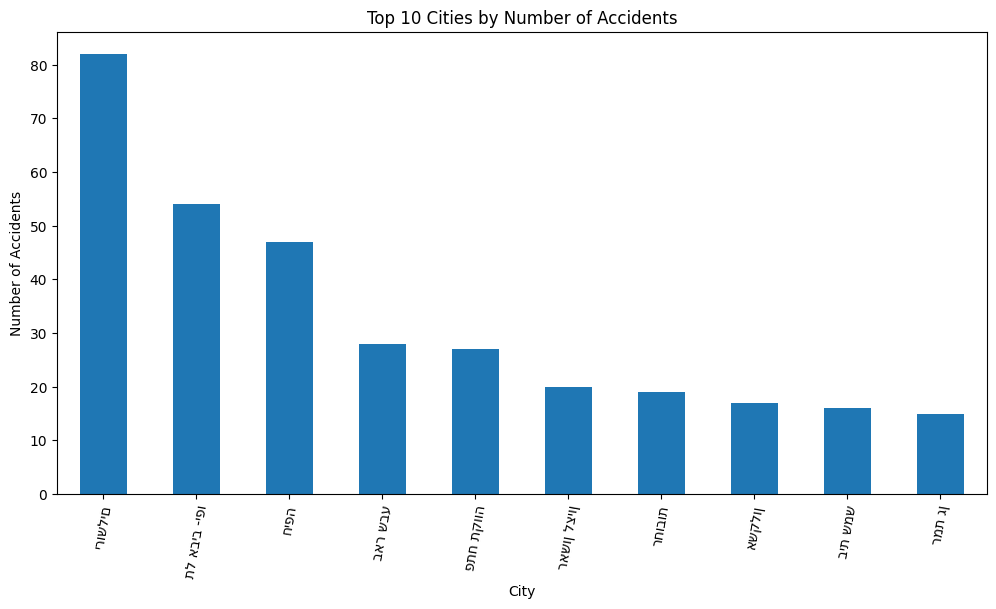

In [ ]:
# Distribution of accidents by CITY
plt.figure(figsize=(12, 6))
data['CITY'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Cities by Number of Accidents')
plt.xlabel('City')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=80)
plt.show()

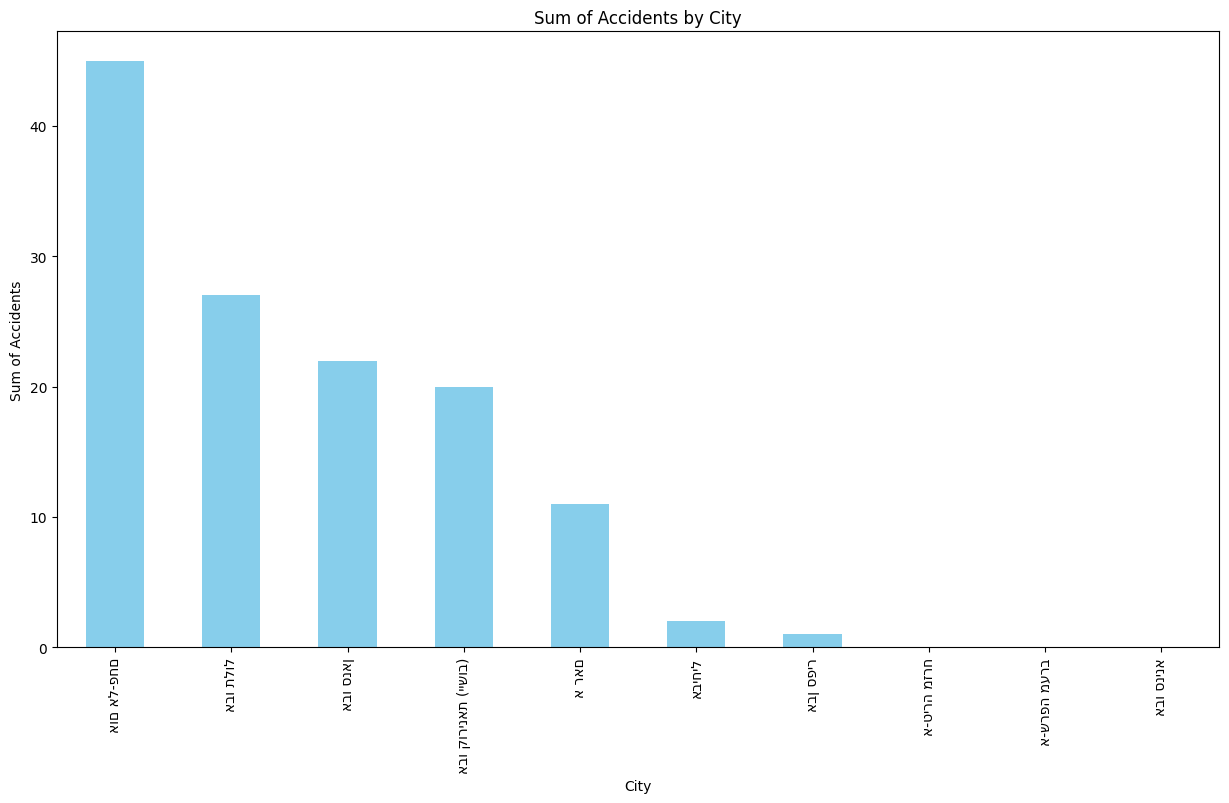

In [ ]:
city_accidents = data.groupby('CITY')['SUMACCIDEN'].sum().head(10)
# Sorting the data by number of accidents (from largest to smallest)
city_accidents = city_accidents.sort_values(ascending=False)
# Plotting the graph
plt.figure(figsize=(15, 8))
city_accidents.plot(kind='bar', color='skyblue')
plt.title('Sum of Accidents by City')
plt.xlabel('City')
plt.ylabel('Sum of Accidents')
plt.xticks(rotation=90)
plt.show()

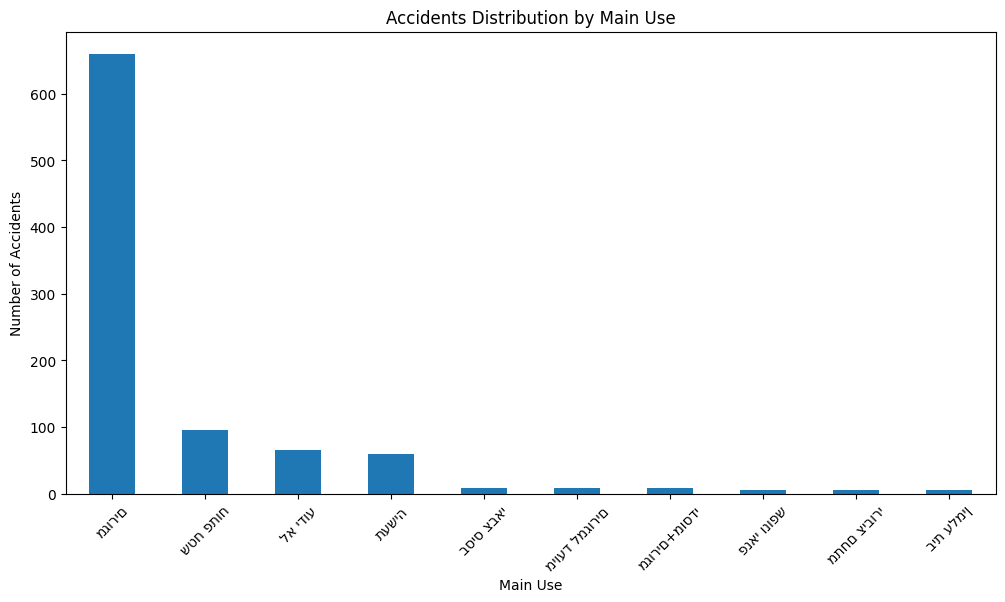

In [ ]:
# Distribution of accidents by Main Use
plt.figure(figsize=(12, 6))
data['MainUse'].value_counts().head(10).plot(kind='bar')
plt.title('Accidents Distribution by Main Use')
plt.xlabel('Main Use')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# First, ensure the YEARMONTH column is present and correctly formatted as a string of year and month.
print(data_preprocessed['YEARMONTH'])

0      202308
1      202308
2      202308
3      202308
4      202308
        ...  
995    202308
996    202308
997    202308
998    202308
999    202308
Name: YEARMONTH, Length: 1000, dtype: int64


In [ ]:
# Convert YEARMONTH to datetime format if conversion is correct
data_preprocessed['YearMonth'] = pd.to_datetime(data_preprocessed['YEARMONTH'], format='%Y%m')

In [ ]:
# Check the range of accident counts to understand the scale
print(data_preprocessed.groupby('YearMonth').size().describe())

count       1.0
mean     1000.0
std         NaN
min      1000.0
25%      1000.0
50%      1000.0
75%      1000.0
max      1000.0
dtype: float64


# יש נתונים רק על שנה אחת וחודש אחד ולכן לא נוכל להסיק ולתת המלצות על סמך זמנים

Text(0, 0.5, 'Number of Accidents')

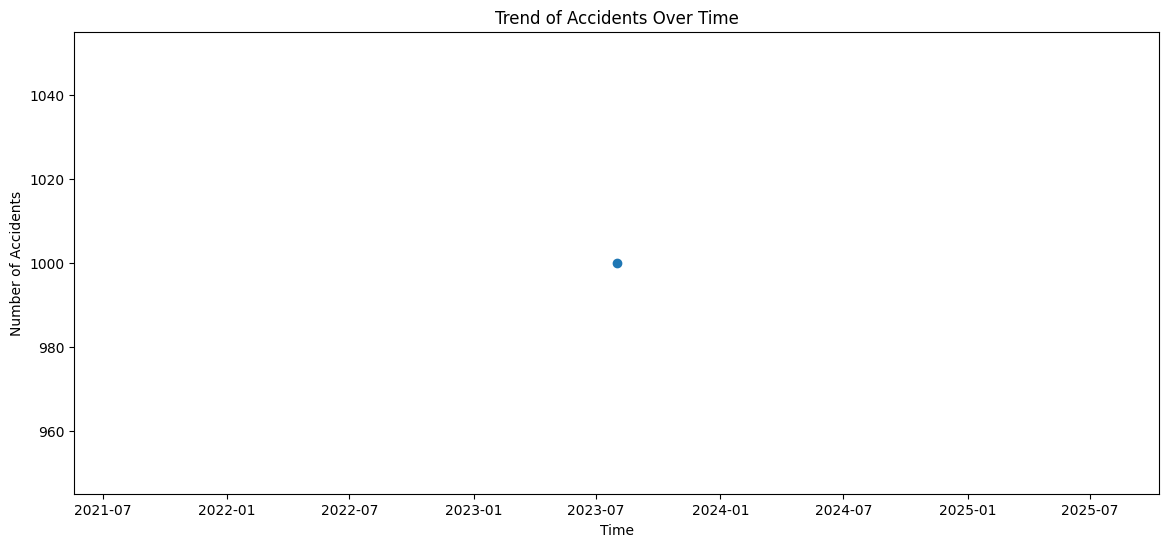

In [ ]:
# Plotting accidents over time with markers and checking for a more detailed view
plt.figure(figsize=(14, 6))
accidents_over_time = data_preprocessed.groupby('YearMonth').size()
plt.plot(accidents_over_time.index, accidents_over_time.values, marker='o') # Adding markers
plt.title('Trend of Accidents Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')

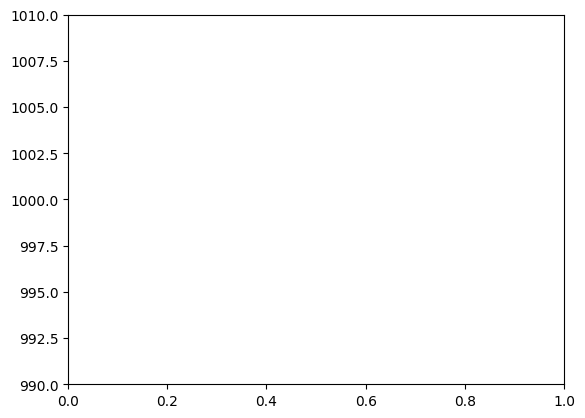

In [ ]:
# Zoom in on the y-axis if needed
plt.ylim(accidents_over_time.min() - 10, accidents_over_time.max() + 10) # Adjust y-axis to zoom in

plt.show()

In [ ]:
# Simplifying the approach by selecting a subset of key features for clustering
simplified_features = data_preprocessed[['Accident_Density_Per_Population', 'Accident_Density_Per_Area', 'ACC_INDEX', 'POP_2018']]

In [ ]:
# Performing K-Means clustering with a predetermined number of clusters (for demonstration, let's use 5 clusters)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(simplified_features)

In [ ]:
# Adding the cluster labels to the dataset
data_preprocessed['Cluster'] = cluster_labels

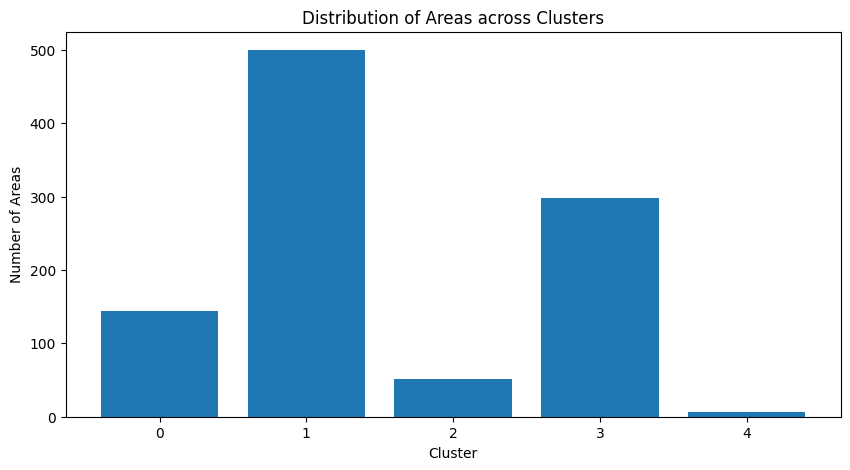

In [ ]:
# Visualizing the distribution of data points among the clusters
#הנתונים מוצגים בצורת עמודות, כאשר כל עמודה מייצגת אחת מהקבוצות (או אשכולות) וגובהה מייצג את מספר האזורים השייכים לכל קבוצה זו][]
cluster_distribution = data_preprocessed['Cluster'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.title('Distribution of Areas across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Areas')
plt.xticks(range(5))
plt.show()

In [ ]:
# Ensure 'Cluster' is treated as a categorical variable
data_preprocessed['Cluster'] = data_preprocessed['Cluster'].astype('category')

In [ ]:
# If 'DEAD' is not already a float or integer, convert it to numeric
# This line is defensive, if 'DEAD' is already numeric, it will have no effect
data_preprocessed['DEAD'] = pd.to_numeric(data_preprocessed['DEAD'], errors='coerce')

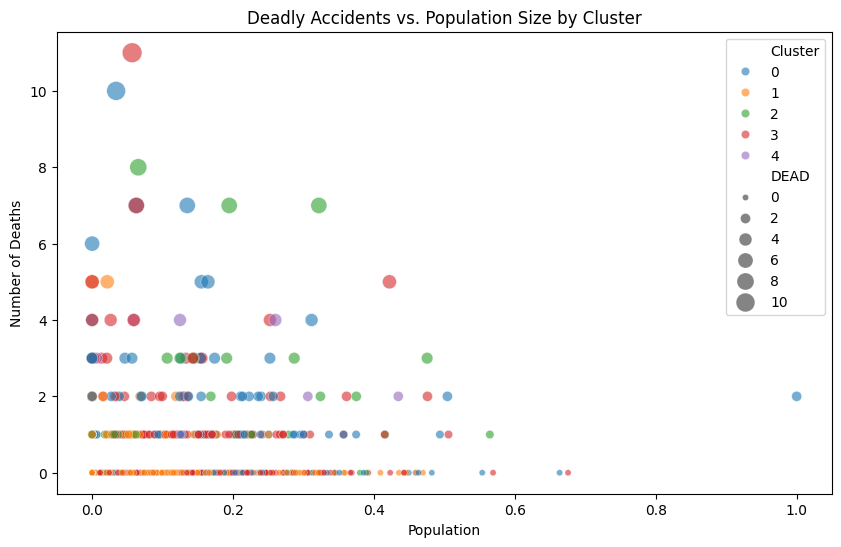

In [ ]:
# Now let's try the scatter plot again
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_preprocessed,
    x='POP_2018',
    y='DEAD',
    hue='Cluster',
    size='DEAD',
    sizes=(20, 200),
    alpha=0.6
)
plt.title('Deadly Accidents vs. Population Size by Cluster')
plt.xlabel('Population')
plt.ylabel('Number of Deaths')
plt.show()

<ipython-input-39-072166ef8324>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_characteristics = data_preprocessed.groupby('Cluster')[['POP_2018', 'TAZAREA', 'DEAD', 'SEVER_INJ']].mean()


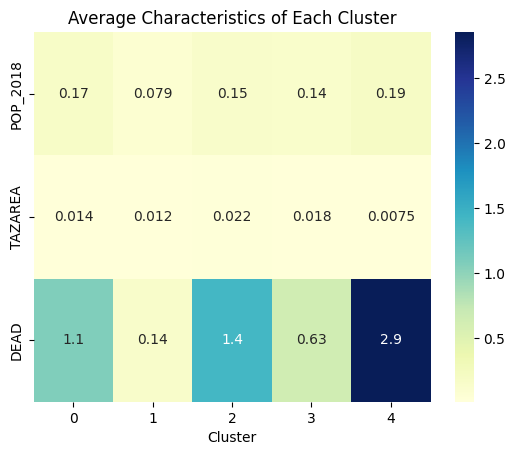

In [ ]:
# Clusters characterization
cluster_characteristics = data_preprocessed.groupby('Cluster')[['POP_2018', 'TAZAREA', 'DEAD', 'SEVER_INJ']].mean()
sns.heatmap(cluster_characteristics.transpose(), cmap='YlGnBu', annot=True)
plt.title('Average Characteristics of Each Cluster')
plt.show()

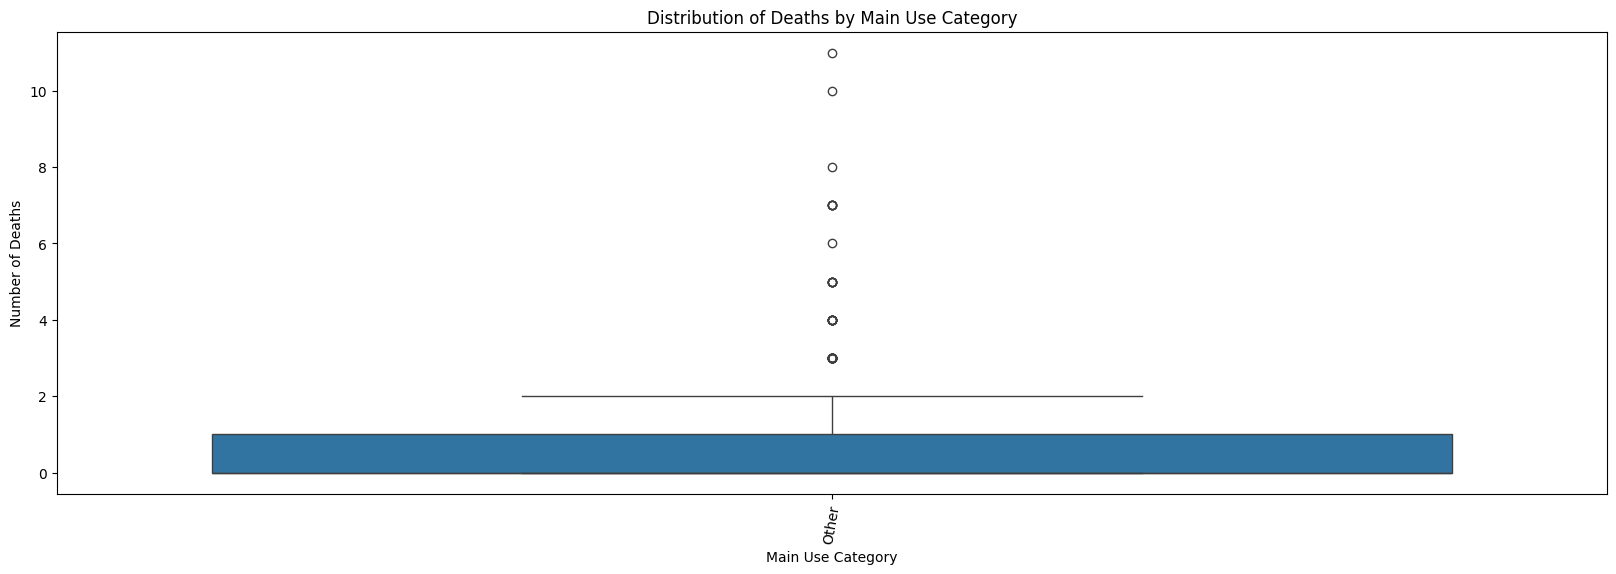

In [ ]:
# Assuming 'MainUse' was originally one-hot encoded into separate columns such as 'MainUse_Residential'
# Let's reverse this process to get a single 'MainUse_category' column

# Create a function to reverse one-hot encoding
def reverse_one_hot(row, prefix):
    for c in row.index:
        if c.startswith(prefix) and row[c] == 1:
            return c[len(prefix):]  # Return the category name
    return 'Other'

# Apply this function to each row
data_preprocessed['MainUse_category'] = data_preprocessed.apply(lambda row: reverse_one_hot(row, 'MainUse_'), axis=1)

# Now we can plot the boxplot with the new 'MainUse_category' column
plt.figure(figsize=(20, 6))
sns.boxplot(data=data_preprocessed, x='MainUse_category', y='DEAD')
plt.title('Distribution of Deaths by Main Use Category')
plt.xlabel('Main Use Category')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=80)
plt.show()


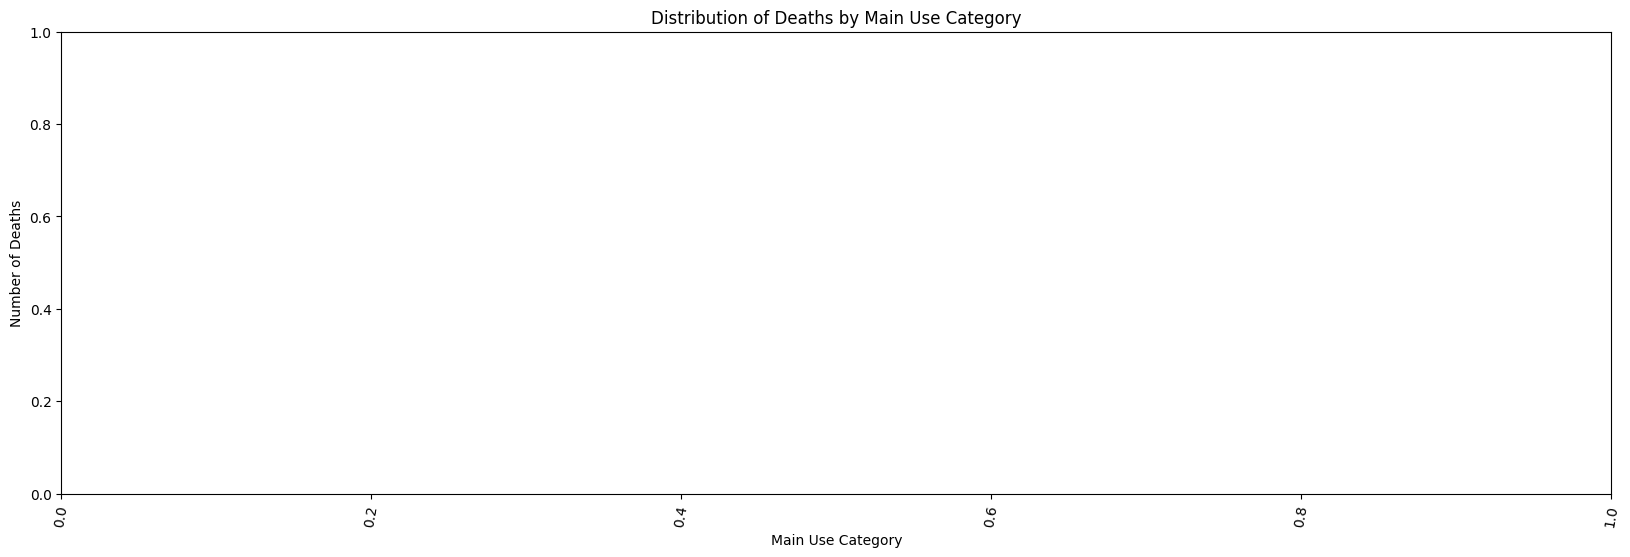

In [ ]:
# Find the one-hot encoded 'MainUse' columns
encoded_columns = [col for col in data_preprocessed.columns if 'MainUse_' in col]

# Melt the one-hot encoded columns back into a single 'MainUse' column
melted_data = pd.melt(data_preprocessed, id_vars=['DEAD'], value_vars=encoded_columns, var_name='MainUse', value_name='IsPresent')

# Filter the melted data to include only rows where the main use category is present
melted_data = melted_data[melted_data['IsPresent'] == 1]

# Plotting the boxplot with the melted data
plt.figure(figsize=(20, 6))
sns.boxplot(data=melted_data, x='MainUse', y='DEAD')
plt.title('Distribution of Deaths by Main Use Category')
plt.xlabel('Main Use Category')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=80)
plt.show()


In [ ]:
# Returning a brief overview of one of the clusters as an example
data_preprocessed[data_preprocessed['Cluster'] == 0].head()

,SUMACCIDEN,POP_2018,TAZAREA,CITYCODE,DEAD,SEVER_INJ,SLIGH_INJ,PEDESTRINJ,INJ0_19,INJ20_64,...,VEHICLE,ACC_INDEX,YEARMONTH,Shape_Length,Shape_Area,Accident_Density_Per_Population,Accident_Density_Per_Area,YearMonth,Cluster,MainUse_category
0,56,0.342774,0.000907,8300,0,14,51,25,13,37,...,0.244300,0.142452,202308,3765.786446,8.529776e+05,41.704696,55.949275,2023-08-01,0,Other
4,44,0.000000,0.000468,6800,0,10,106,0,13,92,...,0.257329,0.187713,202308,3692.333819,5.086013e+05,44.000000,43.979401,2023-08-01,0,Other
7,29,0.103094,0.036566,0,1,8,75,0,11,68,...,0.172638,0.002179,202308,34926.830927,2.887499e+07,26.289686,27.976997,2023-08-01,0,Other
9,32,0.663531,0.000375,6100,0,7,30,27,18,14,...,0.117264,0.159535,202308,2970.819370,4.352237e+05,19.236190,31.988004,2023-08-01,0,Other
29,39,0.000000,0.083599,0,4,14,82,2,15,85,...,0.231270,0.001285,202308,63537.397161,6.583507e+07,39.000000,35.991167,2023-08-01,0,Other


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(simplified_features, cluster_labels)
print("The silhouette score of the clustering: ", silhouette_avg)


The silhouette score of the clustering:  0.5896340957665133


In [ ]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(simplified_features)
    score = silhouette_score(simplified_features, kmeans.labels_)
    silhouette_scores.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

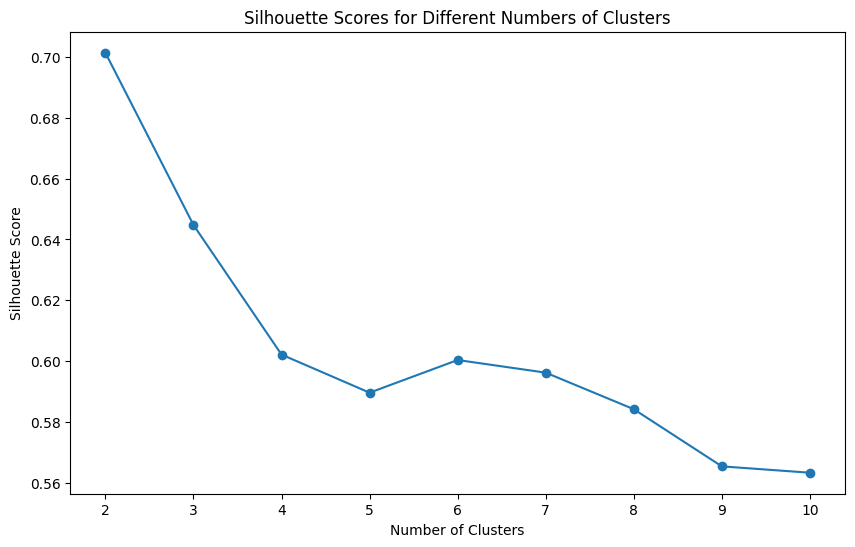

In [ ]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.show()